In [1]:
import numpy as np
import torch

from tqdm import tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')
sns.set(font_scale=1.3, rc={"lines.linewidth": 2.5})

In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [3]:
impath = '/mnt/fs0/datasets/ImageNet21k/'
emb_path = '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects'

# Data

In [4]:
# Class names and labels
names_1k = np.load(os.path.join(emb_path,'names_1k.npy'))
wnids_1k = np.load(os.path.join(emb_path,'wnids_1k.npy'))

In [5]:
# Image preprocessing
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [6]:
from PIL import Image

def get_batch(i, wnid_dir, imgs, batch_size):
    xbatch = []
    for img in imgs[i*batch_size:(i+1)*batch_size]:
        try:
            x = Image.open(os.path.join(wnid_dir, img)).convert('RGB')
            xbatch.append(preprocess(x))
        except OSError: 
            pass

    return torch.stack(xbatch)

In [7]:
from torchvision.utils import make_grid
def show_grid(im_tensor, nrow=8, title=None):
    im_grid = make_grid(im_tensor, nrow=nrow, padding=2)
    im_grid = im_grid.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    im_grid = std * im_grid + mean
    im_grid = np.clip(im_grid, 0, 1)
    
    plt.figure(figsize=(15,2*len(input_tensor)//nrow))
    plt.imshow(im_grid)
    plt.axis('off')
    plt.title(title)

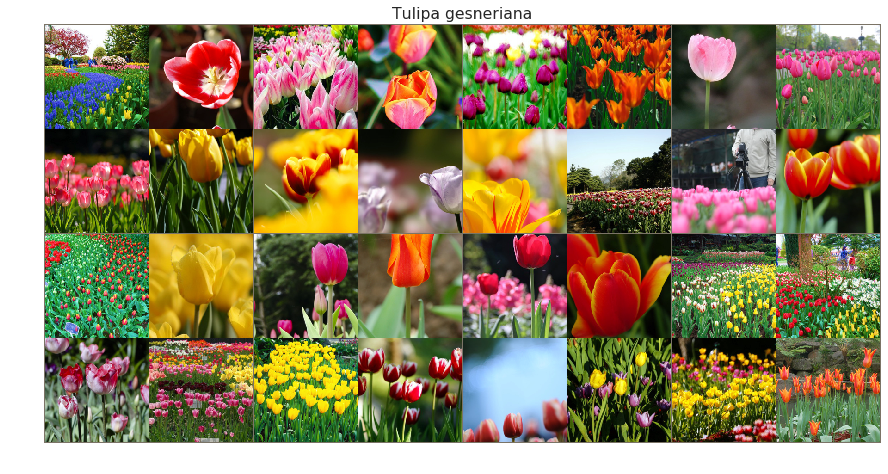

In [8]:
batch_size = 32
i = 12
wnid = wnids_1k[i]
wnid_dir = os.path.join(impath, wnid)
imgs = os.listdir(wnid_dir)

input_tensor = get_batch(0, wnid_dir, imgs, batch_size)

show_grid(input_tensor, title=names_1k[i])

# Model

In [83]:
model_name = 'vgg19'
repo = 'pytorch/vision:v0.6.0'
# repo = 'rwightman/gen-efficientnet-pytorch'
model = torch.hub.load(repo, model_name, pretrained=True)
model.cuda()

model_dir = os.path.join(emb_path,model_name)

Using cache found in /home/bsorsch/.cache/torch/hub/pytorch_vision_v0.6.0


# Embeddings

In [84]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [85]:
layer_names = []

model.features[0].register_forward_hook(get_activation('conv1'))
layer_names.append('conv1')
model.features[2].register_forward_hook(get_activation('conv2'))
layer_names.append('conv2')
model.features[5].register_forward_hook(get_activation('conv3'))
layer_names.append('conv3')
model.features[7].register_forward_hook(get_activation('conv4'))
layer_names.append('conv4')
model.features[10].register_forward_hook(get_activation('conv5'))
layer_names.append('conv5')
model.features[12].register_forward_hook(get_activation('conv6'))
layer_names.append('conv6')
model.features[14].register_forward_hook(get_activation('conv7'))
layer_names.append('conv7')
model.features[16].register_forward_hook(get_activation('conv8'))
layer_names.append('conv8')
model.features[19].register_forward_hook(get_activation('conv9'))
layer_names.append('conv9')
model.features[21].register_forward_hook(get_activation('conv10'))
layer_names.append('conv10')
model.features[23].register_forward_hook(get_activation('conv11'))
layer_names.append('conv11')
model.features[25].register_forward_hook(get_activation('conv12'))
layer_names.append('conv12')
model.features[28].register_forward_hook(get_activation('conv13'))
layer_names.append('conv13')
model.features[30].register_forward_hook(get_activation('conv14'))
layer_names.append('conv14')
model.features[32].register_forward_hook(get_activation('conv15'))
layer_names.append('conv15')
model.features[34].register_forward_hook(get_activation('conv16'))
layer_names.append('conv16')

model.classifier[0].register_forward_hook(get_activation('linear1'))
layer_names.append('linear1')
model.classifier[3].register_forward_hook(get_activation('linear2'))
layer_names.append('linear2')
model.classifier[6].register_forward_hook(get_activation('linear3'))
layer_names.append('linear3')

In [11]:
layer_names = []
model.conv1.register_forward_hook(get_activation('conv1'))
layer_names.append('conv1')

model.layer1[0].register_forward_hook(get_activation('layer1_bottleneck1'))
layer_names.append('layer1_bottleneck1')
model.layer1[1].register_forward_hook(get_activation('layer1_bottleneck2'))
layer_names.append('layer1_bottleneck2')
model.layer1[2].register_forward_hook(get_activation('layer1_bottleneck3'))
layer_names.append('layer1_bottleneck3')

model.layer2[0].register_forward_hook(get_activation('layer2_bottleneck1'))
layer_names.append('layer2_bottleneck1')
model.layer2[1].register_forward_hook(get_activation('layer2_bottleneck2'))
layer_names.append('layer2_bottleneck2')
model.layer2[2].register_forward_hook(get_activation('layer2_bottleneck3'))
layer_names.append('layer2_bottleneck3')
model.layer2[3].register_forward_hook(get_activation('layer2_bottleneck4'))
layer_names.append('layer2_bottleneck4')

model.layer3[0].register_forward_hook(get_activation('layer3_bottleneck1'))
layer_names.append('layer3_bottleneck1')
model.layer3[1].register_forward_hook(get_activation('layer3_bottleneck2'))
layer_names.append('layer3_bottleneck2')
model.layer3[2].register_forward_hook(get_activation('layer3_bottleneck3'))
layer_names.append('layer3_bottleneck3')
model.layer3[3].register_forward_hook(get_activation('layer3_bottleneck4'))
layer_names.append('layer3_bottleneck4')
model.layer3[4].register_forward_hook(get_activation('layer3_bottleneck5'))
layer_names.append('layer3_bottleneck5')
model.layer3[5].register_forward_hook(get_activation('layer3_bottleneck6'))
layer_names.append('layer3_bottleneck6')

model.layer4[0].register_forward_hook(get_activation('layer4_bottleneck1'))
layer_names.append('layer4_bottleneck1')
model.layer4[1].register_forward_hook(get_activation('layer4_bottleneck2'))
layer_names.append('layer4_bottleneck2')
model.layer4[2].register_forward_hook(get_activation('layer4_bottleneck3'))
layer_names.append('layer4_bottleneck3')

model.avgpool.register_forward_hook(get_activation('avgpool'))
layer_names.append('avgpool')

In [79]:
# Construct indices with which to randomly subsample neurons
with torch.no_grad():
    _ = model(input_tensor)   # test batch

subsample_idxs = []
for name in layer_names:
    M = np.prod(activation[name].shape[1:])
    subsample_idxs.append(np.random.choice(np.arange(M),2048))

In [86]:
N = 1024
P = 500
batch_size = 10

manifolds_all = {}
for name in layer_names:
    manifolds_all[name] = []

for wnid in tqdm(wnids_1k[:10],leave=False):
    wnid_dir = os.path.join(impath, wnid)
    imgs = os.listdir(wnid_dir)

    manifold = {}
    for name in layer_names:
        manifold[name] = []
        
    for i in range(P//batch_size+5):
        input_tensor = get_batch(i, wnid_dir, imgs, batch_size)
        with torch.no_grad():
            _ = model(input_tensor.cuda())
            
        for name,idxs in zip(layer_names,subsample_idxs):
            output = activation[name]
            output = output.reshape(output.shape[0],-1)[:,idxs]
            manifold[name].append(output.cpu().numpy())
            
    for name in layer_names:
        manifolds_all[name].append(np.vstack(manifold[name]))

In [89]:
if not os.path.isdir(os.path.join(model_dir, 'layerwise_new')):
    os.mkdir(os.path.join(model_dir, 'layerwise_new'))

In [90]:
np.save(os.path.join(model_dir, 'layerwise_new','manifolds_all.npy'),manifolds_all)

# Geometry

In [92]:
def compute_geometry(manifolds):
    # Radius, centers, subspaces
    Rs = []
    centers = []
    Us = []
    for manifold in tqdm(manifolds,leave=False):
        center = manifold.mean(0)
        centers.append(center)
        _,R,U = np.linalg.svd(manifold - center)
        Rs.append(R[:P])
        Us.append(U[:P])
    Rs = np.stack(Rs)
    centers = np.stack(centers)
    Us = np.stack(Us)
    
    # Overlaps
    K = len(manifolds)
    ss = []
    csa = []
    csb = []
    for a in tqdm(range(K),leave=False):
        for b in range(K):
            if a!=b:
                # Center-subspace
                dx0 = centers[a] - centers[b]
                dx0hat = dx0 / np.linalg.norm(dx0)
                costheta_a = Us[a]@dx0hat
                csa.append((costheta_a**2 * Rs[a]**2).sum() / (Rs[a]**2).sum())
                costheta_b = Us[b]@dx0hat
                csb.append((costheta_b**2 * Rs[b]**2).sum() / (Rs[a]**2).sum())

                # Subspace-subspace
                cosphi = Us[a]@Us[b].T
                ss_overlap = (cosphi**2*Rs[a][:,None]**2*Rs[b]**2).sum() / (Rs[a]**2).sum()**2
                ss.append(ss_overlap)
            else:
                csa.append(np.nan)
                csb.append(np.nan)
                ss.append(np.nan)
    csa = np.stack(csa).reshape(K,K)
    csb = np.stack(csb).reshape(K,K)
    ss = np.stack(ss).reshape(K,K)
    
    return Rs, Us, centers, csa, csb, ss

In [24]:
model_name = 'resnet50'
model_dir = os.path.join(emb_path,model_name)

In [25]:
manifolds_all = np.load(os.path.join(model_dir, 'layerwise','manifolds_all.npy'))

In [74]:
# # Project to 88 dimensions
# N = 1024
# M = 88
# A = np.random.randn(N,M) / np.sqrt(M)

# P = 500
# manifolds_all = []
# for manifolds in tqdm(manifolds_all_load):
#     manifolds_all.append(manifolds[:,:P]@A)
# manifolds_all = np.stack(manifolds_all)

In [93]:
Rs_all = []
Us_all = []
centers_all = []
csa_all = []
csb_all = []
ss_all = []
for layer_name in tqdm(layer_names):
    manifolds = manifolds_all[layer_name]
    Rs, Us, centers, csa, csb, ss = compute_geometry(manifolds)
    Rs_all.append(Rs)
    Us_all.append(Us)
    centers_all.append(centers)
    csa_all.append(csa)
    csb_all.append(csb)
    ss_all.append(ss)

In [94]:
Rs_all = np.stack(Rs_all)

In [95]:
Ds = (Rs_all**2).sum(-1)**2 / (Rs_all**4).sum(-1)

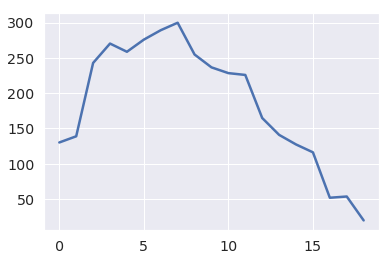

In [97]:
plt.plot(Ds.mean(-1))

In [107]:
R2 = (Rs_all**2).sum(-1)
bias = R2[:,None]/R2[:,:,None] - 1

In [98]:
np.save(os.path.join(model_dir, 'layerwise_new','Rs_all.npy'),Rs_all)
np.save(os.path.join(model_dir, 'layerwise_new','Us_all.npy'),Us_all)
np.save(os.path.join(model_dir, 'layerwise_new','centers_all.npy'),centers_all)
np.save(os.path.join(model_dir, 'layerwise_new','csa_all.npy'),csa_all)
np.save(os.path.join(model_dir, 'layerwise_new','csb_all.npy'),csb_all)
np.save(os.path.join(model_dir, 'layerwise_new','ss_all.npy'),ss_all)

In [99]:

model_dir_resnet = os.path.join(emb_path,'resnet50')

In [104]:
Rs_all_50 = np.load(os.path.join(model_dir_resnet, 'layerwise_new','Rs_all.npy'))

In [105]:
Ds50 = (Rs_all_50**2).sum(-1)**2 / (Rs_all_50**4).sum(-1)

In [110]:
R250 = (Rs_all_50**2).sum(-1)
bias50 = R250[:,None]/R250[:,:,None] - 1

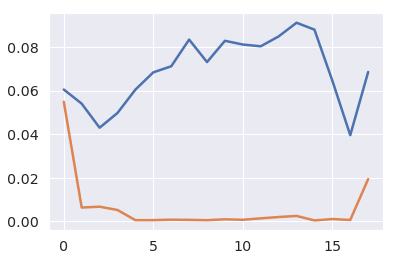

In [116]:
plt.plot(bias[np.arange(19)!=15].mean((1,2)))
plt.plot(bias50.mean((1,2)))

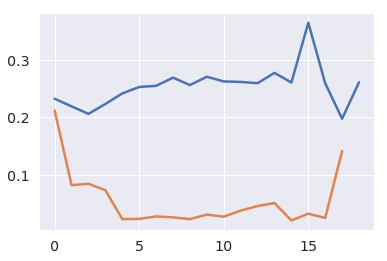

In [122]:
plt.plot(R2.std(-1)/R2.mean(-1))
plt.plot(R250.std(-1)/R250.mean(-1))

In [119]:
R250.shape

(18, 10)

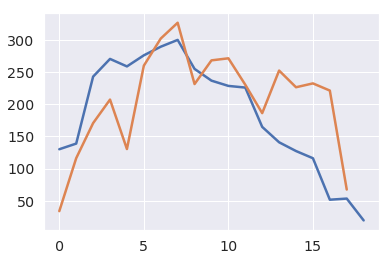

In [106]:
plt.plot(Ds.mean(-1))
plt.plot(Ds50.mean(-1))

# Generalization error

In [32]:
from jax import numpy as np
from jax import jit
from jax import random
key = random.PRNGKey(0)

In [43]:
n_avg = 1000
m = 1

@jit
def shuffle(key,Xa,Xb):
    ''' Randomly shuffle examples in Xa and Xb along the zeroth axis.
    Args: 
        key: random PRNGkey
        Xa: (P,N) first array to shuffle
        Xb: (P,N) second array to shuffle
    
    Returns:
        Xaperm: (P,N) shuffled copy of Xa
        Xbperm: (P,N) shuffled copy of Xb
    '''
    keya,keyb=random.split(key)
    perma = random.shuffle(keya,np.arange(len(Xa)))
    permb = random.shuffle(keyb,np.arange(len(Xb)))
    
    return Xa[perma],Xb[permb]


@jit
def mshot_err(X):
    ''' Performs an m-shot learning experiment on a pair of shuffled manifolds X=(Xa,Xb).
    Args: 
        m: # training examples
        X: X=(Xa,Xb), a pair of (P,N) object manifolds, pre-shuffled along the zeroth axis.
    
    Returns:
        erra: m-shot learning error evaluated on manifold a
        errb: m-shot learning error evaluated on manifold b
    '''
    Xa,Xb = X
    xatrain, xatest = np.split(Xa, (m,))
    xa = xatrain.mean(0)
    xbtrain, xbtest = np.split(Xb, (m,))
    xb = xbtrain.mean(0)
    x = np.vstack([xa,xb])

    distsa = ((x[:,None] - xatest[None])**2).sum(-1)
    ya = distsa.argmin(0)

    distsb = ((x[:,None] - xbtest[None])**2).sum(-1)
    yb = distsb.argmin(0)

    erra = (ya!=0).mean()
    errb = (yb!=1).mean()

    return erra, errb


@jit
def mshot_err_fast(key,Xa,Xb):
    ''' Performs a quick heuristic m-shot learning experiment on a pair of manifolds X=(Xa,Xb),
    allowing overlap between training and test examples.
    
    Args: 
        X: X=(Xa,Xb), a pair of (P,N) object manifolds, pre-shuffled along the zeroth axis.
    
    Returns:
        erra: m-shot learning error evaluated on manifold a
        errb: m-shot learning error evaluated on manifold b
    '''
    keya, keyb = random.split(key)
    idxs_a = random.randint(keya, (m,n_avg), 0,P)
    idxs_b = random.randint(keyb, (m,n_avg), 0,P)
    
    # Prototypes
    xabar = Xa[idxs_a].mean(0)
    xbbar = Xb[idxs_b].mean(0)

    # Distances to prototypes
    daa = ((Xa[:,None] - xabar[None])**2).sum(-1)
    dab = ((Xa[:,None] - xbbar[None])**2).sum(-1)
    dba = ((Xb[:,None] - xabar[None])**2).sum(-1)
    dbb = ((Xb[:,None] - xbbar[None])**2).sum(-1)
    ha = -daa + dab
    hb = -dbb + dba

    erra = (ha<0).mean()
    errb = (hb<0).mean()

    return erra, errb

In [44]:
manifolds = np.array(manifolds)

In [53]:
from scipy.spatial.distance import squareform

def pairwise_err(key,manifolds):
    K = len(manifolds)
    errsa = []
    errsb = []
    for a in tqdm(range(K)):
        Xa = manifolds[a]
        for b in range(a+1,K):
            Xb = manifolds[b]
            key,_ = random.split(key)
            erra,errb = mshot_err_fast(key,Xa,Xb)
            errsa.append(erra)
            errsb.append(errb)
    errs = np.triu(squareform(errsa)) + np.tril(squareform(errsb))
    return errs

In [55]:
K = 100
err_means_all = []
for manifolds in tqdm(manifolds_all):
    manifolds = np.stack(manifolds)
    err_means = pairwise_err(key,manifolds)
    err_means_all.append(err_means)
err_means_all = np.stack(err_means_all)

In [56]:
np.save(os.path.join(model_dir, 'layerwise','err_means_all.npy'), err_means_all)

# Theory

In [20]:
model_name = 'resnet50'
model_dir = os.path.join(emb_path,model_name)

In [142]:
errs_1shot = np.load(os.path.join(model_dir, 'errs_1shot.npy'))
# errs_5shot = np.load(os.path.join(model_dir, 'errs_5shot.npy'))

In [139]:
centers = np.load(os.path.join(model_dir,'centers.npy'))
Rs = np.load(os.path.join(model_dir,'Rs.npy'))
# Us = np.load(os.path.join(model_dir,'Us.npy'))

In [140]:
from scipy.spatial.distance import pdist, squareform
dists = squareform(pdist(centers))
dist_norm = dists / np.sqrt((Rs**2).mean(-1)[:,None])

Dsvds = np.sum(Rs**2,axis=-1)**2 / np.sum(Rs**4, axis=-1)
print('Mean Dsvd: ' + str(np.mean(Dsvds)))

Mean Dsvd: 36.286297


In [21]:
csa = np.load(os.path.join(model_dir,'center_subspace_a.npy'))
csb = np.load(os.path.join(model_dir,'center_subspace_b.npy'))
ss = np.load(os.path.join(model_dir,'subspace_subspace.npy'))

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/resnet50/center_subspace_a.npy'

In [143]:
from utils import make_square
errs = make_square(errs_1shot)

In [219]:
m = 1
n_plots = 1000
K = centers.shape[0]
css = (csa + csb/m) * dist_norm[:n_plots]**2
bias = (Rs**2).sum(-1) / (Rs**2).sum(-1)[:,None] - 1
signal = dist_norm[:n_plots]**2 + bias[:n_plots]/m
noise = np.sqrt(1/Dsvds/m + 1/Dsvds/m/2 + ((Rs**2).sum(-1)/(Rs**2).sum(-1)[:,None])/Dsvds[:,None]/m/2+ css[:n_plots] + ss[:n_plots]/m)
SNR = 1/2*signal / noise

In [220]:
from scipy.special import erfc

def H(x):
    return 1/2*erfc(x/np.sqrt(2))

In [221]:
from scipy.stats import binned_statistic

In [222]:
vals, bins, binnum = binned_statistic(np.nan_to_num(SNR.ravel()), errs.ravel(), bins=100)

(0.0001, 1)

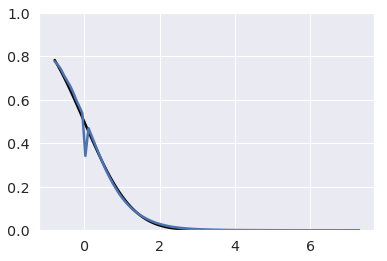

In [223]:
plt.plot(bins[1:], H(bins[1:]), c='black')
plt.plot(bins[1:],vals)
# plt.yscale('log')
# plt.xscale('log')
plt.ylim(1e-4,1)

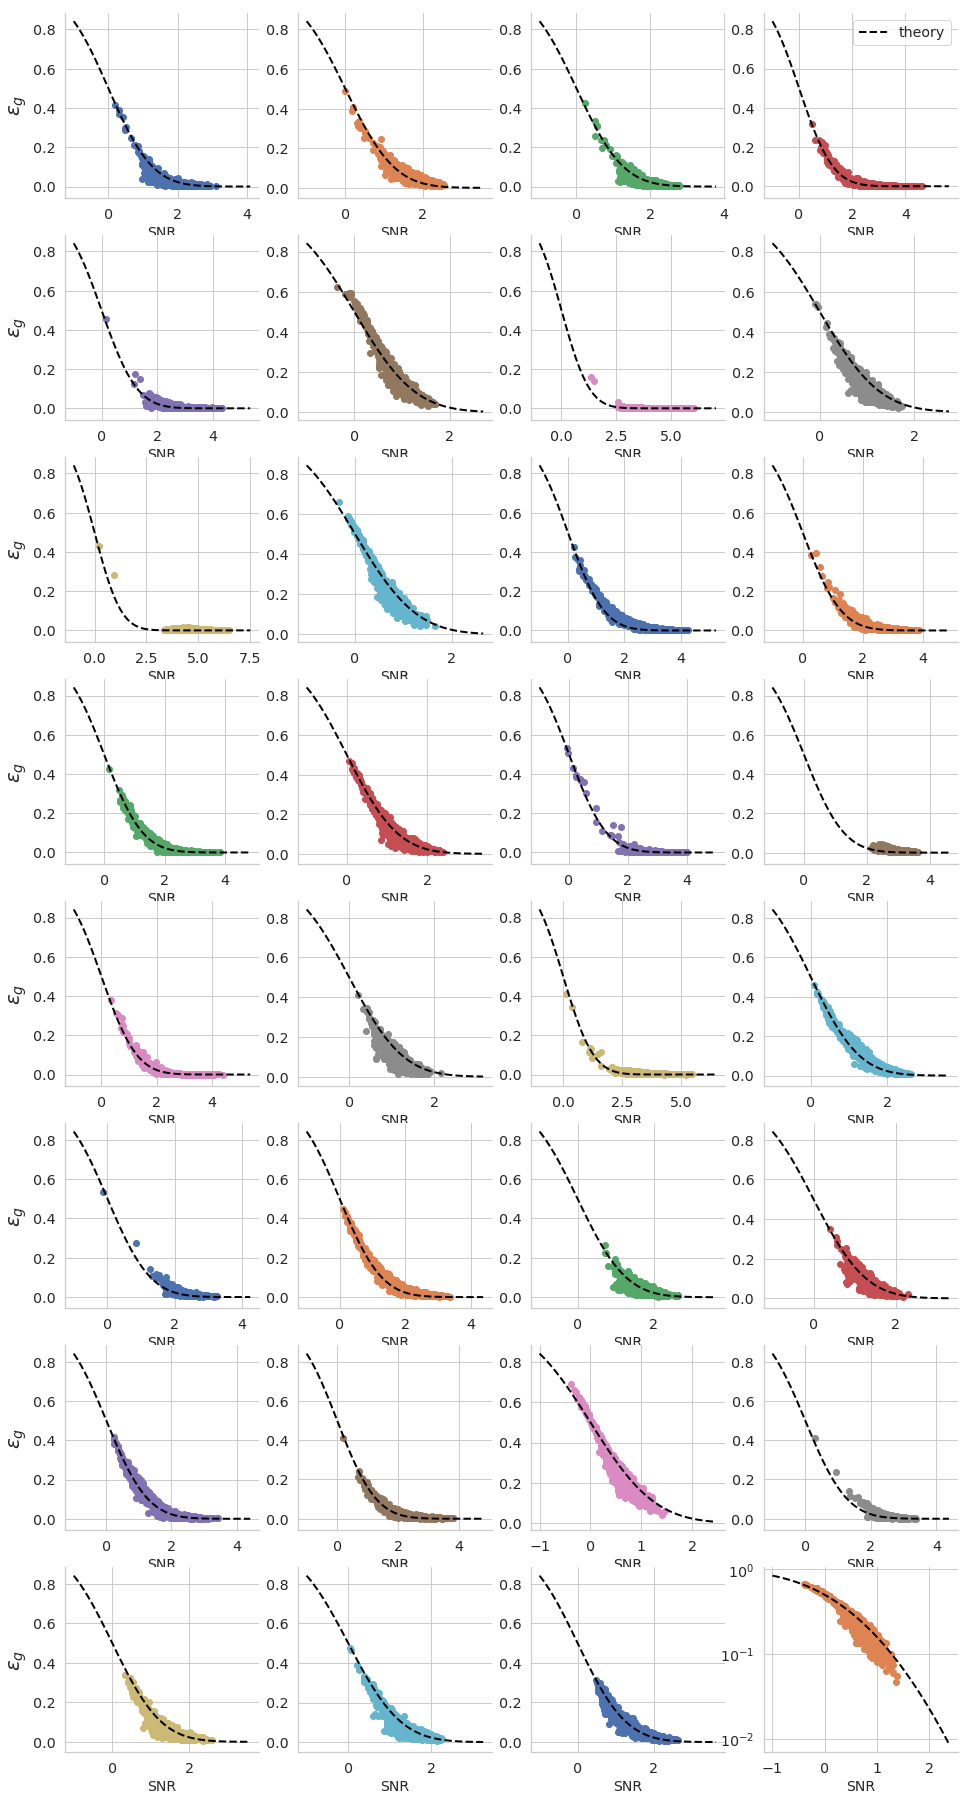

In [224]:
n_plots = 32
n_classes = 1000
with sns.axes_style('whitegrid'):    
    plt.figure(figsize=(16, n_plots//4*4))
    c = 0
    for i in range(n_plots):
        plt.subplot(n_plots//4,4,i+1)
        plt.scatter(SNR[i][np.arange(K)!=i],errs_5shot[i], c='C' + str(c%10))
        c+=1  # update color counter

        # Plot theory
        x = np.linspace(-1,np.nanmax(SNR[i])+1,50)
        plt.plot(x, H(x), c='black', linestyle='dashed', linewidth=2, label='theory')

        plt.xlabel('SNR', fontsize=14)
        if i%4==0:
            plt.ylabel(r'$\epsilon_g$', fontsize=20)
        if c==4:
            plt.legend()
        sns.despine()
plt.yscale('log')

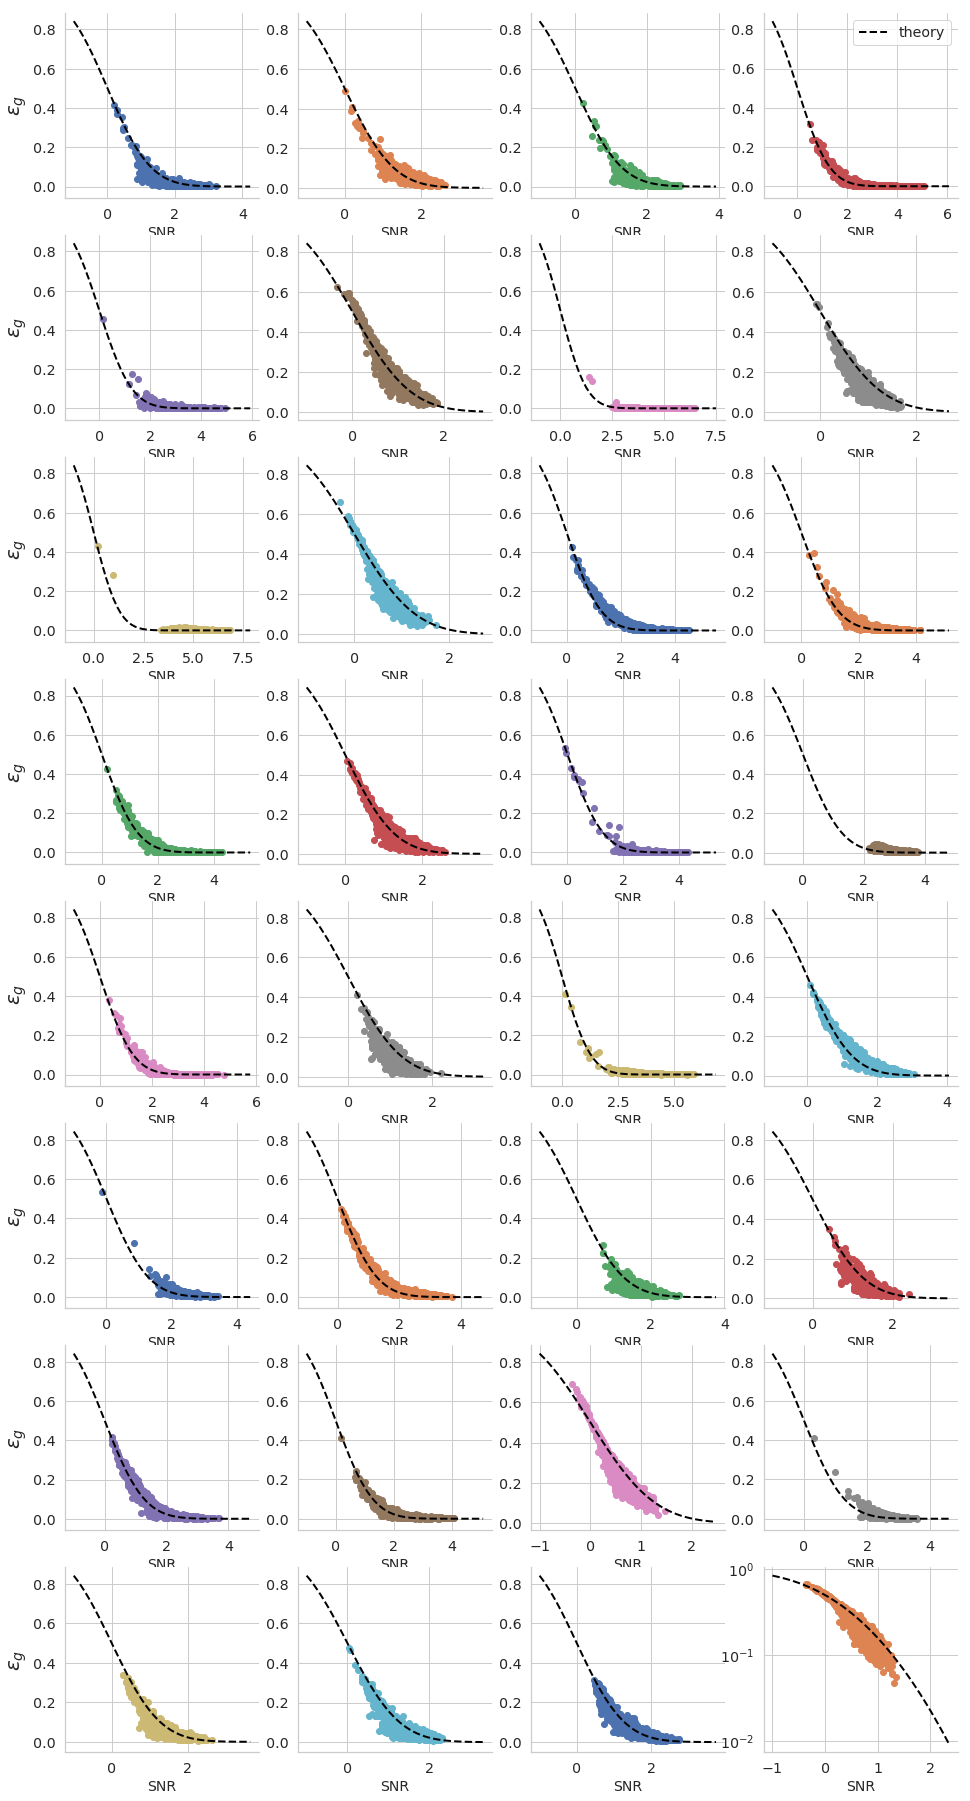

In [30]:
n_plots = 32
n_classes = 1000
with sns.axes_style('whitegrid'):    
    plt.figure(figsize=(16, n_plots//4*4))
    c = 0
    for i in range(n_plots):
        plt.subplot(n_plots//4,4,i+1)
        plt.scatter(SNR[i][np.arange(K)!=i],errs_5shot[i], c='C' + str(c%10))
        c+=1  # update color counter

        # Plot theory
        x = np.linspace(-1,np.nanmax(SNR[i])+1,50)
        plt.plot(x, H(x), c='black', linestyle='dashed', linewidth=2, label='theory')

        plt.xlabel('SNR', fontsize=14)
        if i%4==0:
            plt.ylabel(r'$\epsilon_g$', fontsize=20)
        if c==4:
            plt.legend()
        sns.despine()
plt.yscale('log')

# Layerwise geometry

In [17]:
modelname = 'resnet50'
model_dir = os.path.join(root,modelname)

In [4]:
from scipy.spatial.distance import pdist,squareform
root = '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/'
err_root = '/mnt/fs2/bsorsch/manifold/embeddings/1k_objects/'

def load_geometry(modelname, m):
    model_dir = os.path.join(root,modelname)
    Rs_all = np.load(os.path.join(model_dir, 'layerwise_small','Rs_all.npy'),)
    centers_all = np.load(os.path.join(model_dir, 'layerwise_small','centers_all.npy'),)
    csa_all = np.load(os.path.join(model_dir, 'layerwise_small','csa_all.npy'),)
    csb_all = np.load(os.path.join(model_dir, 'layerwise_small','csb_all.npy'),)
    ss_all = np.load(os.path.join(model_dir, 'layerwise_small','ss_all.npy'),)
    err_all = np.load(os.path.join(model_dir, 'layerwise','err_means_all.npy'),)

    Ds_all = (Rs_all**2).sum(-1)**2 / (Rs_all**4).sum(-1)
    dist_norms = []
    SNRs = []
    for centers,Rs,Ds,ss,csa,csb in zip(centers_all,Rs_all,Ds_all,ss_all,csa_all,csb_all):
        dists = squareform(pdist(centers))
        dist_norm = dists / np.sqrt((Rs**2).mean(-1)[:,None])
        dist_norms.append(dist_norm)

        css = (csa + csb/m) * dist_norm**2
        bias = (Rs**2).sum(-1) / (Rs**2).sum(-1)[:,None] - 1
        SNR = 1/2*(dist_norm**2 + bias/m)/ np.sqrt(1/Ds/m + css + ss/m)
        SNRs.append(SNR)
    dist_norms = np.stack(dist_norms)
    SNRs = np.stack(SNRs)
    
    return SNRs,dist_norms,Ds_all,csa_all,err_all

In [5]:
modelname='resnet50_untrained'
model_dir = os.path.join(root,modelname)
# manifolds_all_un = np.load(os.path.join(model_dir, 'layerwise','manifolds_all.npy'),)
ss_all = np.load(os.path.join(model_dir, 'layerwise','ss_all.npy'),)

In [6]:
m = 5
SNR_un,dist_norm_un,Ds_un,csa_un,err_all_un = load_geometry('resnet50_untrained', m)
SNR_50,dist_norm_50,Ds_50,csa_50,err_all_50 = load_geometry('resnet50', m)
SNR_152,dist_norm_152,Ds_152,csa_152,err_all_152 = load_geometry('resnet152', m)
SNR_vgg,dist_norm_vgg,Ds_vgg,csa_vgg,err_all_vgg = load_geometry('vgg19', m)

In [7]:
from scipy.special import erfc

def H(x):
    return erfc(x/np.sqrt(2))/2

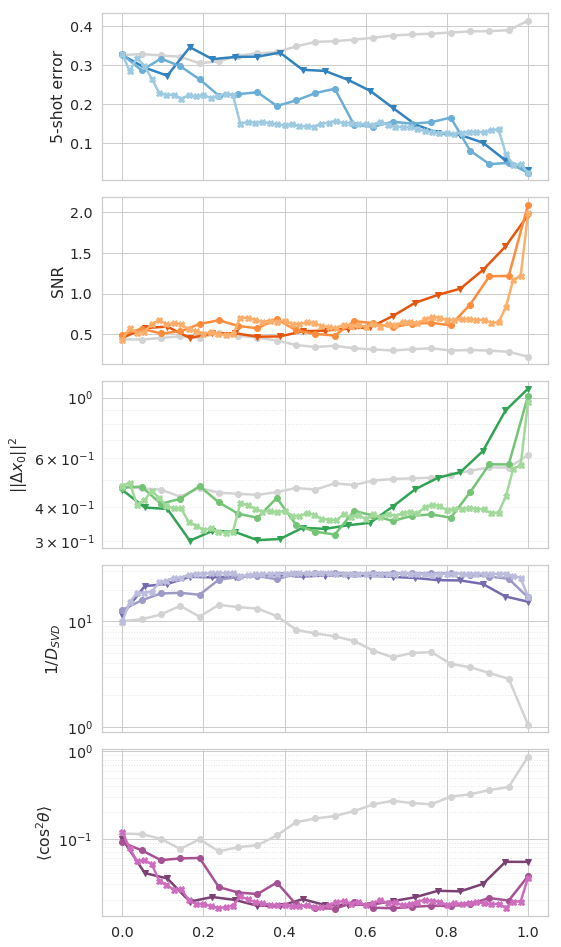

In [11]:
xrn = np.arange(len(Ds_50)) / (len(Ds_50)-1)
x_vgg = np.arange(len(Ds_vgg))*(len(Ds_50)-1)/(len(Ds_vgg)-1) / (len(Ds_50)-1)
xrn152 = np.arange(len(Ds_152))*(len(Ds_50)-1)/(len(Ds_152)-1) / (len(Ds_50)-1)

m = 1
K = 100
mask = np.eye(K,dtype='bool')
cm = sns.color_palette('tab20c')
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8,20))
fmt_vgg = 'v-'
fmt_rn50 = 'o-'
fmt_rn152 = 'X-'

# Error
ax = plt.subplot(611)
plt.plot(xrn,err_all_un.mean((1,2)), fmt_rn50, c='lightgrey', label='Untrained')
plt.plot(x_vgg,err_all_vgg.mean((1,2)), fmt_vgg, c=cm[0], label='VGG19')
plt.plot(xrn,err_all_50.mean((1,2)), fmt_rn50, c=cm[1], label='ResNet50')
plt.plot(xrn152,err_all_152.mean((1,2)), fmt_rn152, c=cm[2], label='ResNet152')
plt.ylabel('5-shot error')
# plt.yscale('log')
ax.xaxis.set_ticklabels([]);

# SNR
ax2 = plt.subplot(612)
plt.plot(xrn,SNR_un[:,~mask].mean(-1), fmt_rn50, c='lightgrey', label='Untrained')
plt.plot(x_vgg,SNR_vgg[:,~mask].mean(-1), fmt_vgg, c=cm[0+4], label='VGG19')
plt.plot(xrn,SNR_50[:,~mask].mean(-1), fmt_rn50, c=cm[1+4], label='ResNet50')
plt.plot(xrn152,SNR_152[:,~mask].mean(-1), fmt_rn152, c=cm[2+4], label='ResNet152')
plt.ylabel('SNR')
# plt.yscale('log')
ax2.xaxis.set_ticklabels([]);

# Distance
ax3 = plt.subplot(613)
plt.plot(xrn,dist_norm_un[:,~mask].mean(-1), fmt_rn50, c='lightgrey', label='Untrained')
plt.plot(x_vgg,dist_norm_vgg[:,~mask].mean(-1), fmt_vgg, c=cm[0+8], label='VGG19')
plt.plot(xrn,dist_norm_50[:,~mask].mean(-1), fmt_rn50, c=cm[1+8], label='ResNet50')
plt.plot(xrn152,dist_norm_152[:,~mask].mean(-1), fmt_rn152, c=cm[2+8], label='ResNet152')
plt.ylabel(r'$||\Delta x_0||^2$')
plt.yscale('log')
ax3.xaxis.set_ticklabels([]);

# Dimension
ax4 = plt.subplot(614)
plt.plot(xrn,Ds_un.mean(-1), fmt_rn50, c='lightgrey', label='Untrained')
plt.plot(x_vgg,Ds_vgg.mean(-1), fmt_vgg, c=cm[0+12], label='VGG19')
plt.plot(xrn,Ds_50.mean(-1), fmt_rn50, c=cm[1+12], label='ResNet50')
plt.plot(xrn152,Ds_152.mean(-1), fmt_rn152, c=cm[2+12], label='ResNet152')
plt.ylabel(r'$1/D_{SVD}$')
plt.yscale('log')
ax4.xaxis.set_ticklabels([]);

# Center-subspace
ax5 = plt.subplot(615)
cm = sns.color_palette('tab20b')
plt.plot(xrn,csa_un[:,~mask].mean(-1), fmt_rn50, c='lightgrey', label='Untrained')
plt.plot(x_vgg,csa_vgg[:,~mask].mean(-1), fmt_vgg, c=cm[0+16], label='VGG19')
plt.plot(xrn,csa_50[:,~mask].mean(-1), fmt_rn50, c=cm[1+16], label='ResNet50')
plt.plot(xrn152,csa_152[:,~mask].mean(-1), fmt_rn152, c=cm[2+16], label='ResNet152')
plt.ylabel(r'$\langle \cos^2\theta\rangle$')
plt.yscale('log')

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, len(Ds_152), 5)
minor_ticks = np.arange(0, len(Ds_152))

# And a corresponding grid
ax2.grid(which='minor')
ax2.grid(which='minor', linestyle=':', alpha=0.5)
ax3.grid(which='minor', linestyle=':', alpha=0.5)
ax4.grid(which='minor', linestyle=':', alpha=0.5)
ax5.grid(which='minor', linestyle=':', alpha=0.5)

plt.subplots_adjust(wspace=0, hspace=0.1)
# plt.savefig('images/layerwise.pdf')

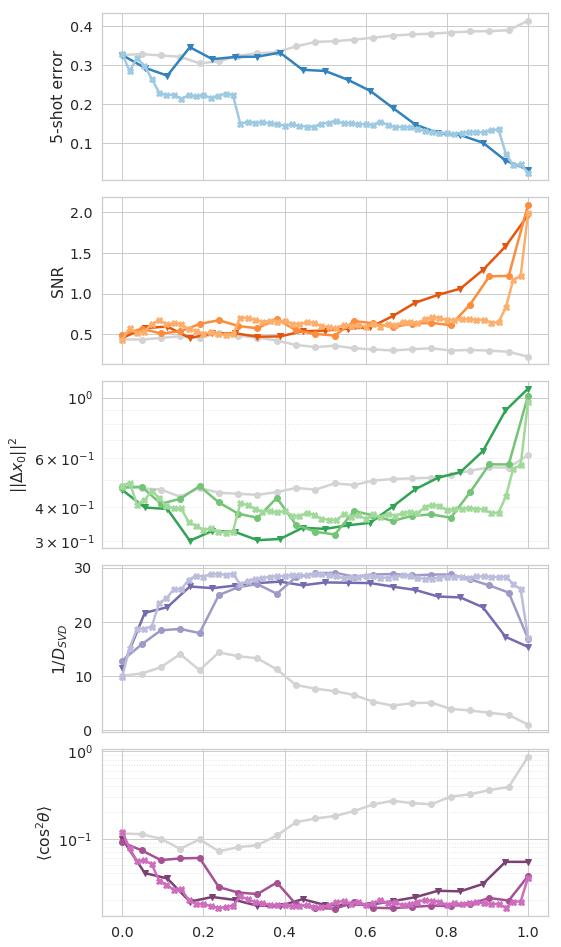

In [88]:
xrn = np.arange(len(Ds_50)) / (len(Ds_50)-1)
x_vgg = np.arange(len(Ds_vgg))*(len(Ds_50)-1)/(len(Ds_vgg)-1) / (len(Ds_50)-1)
xrn152 = np.arange(len(Ds_152))*(len(Ds_50)-1)/(len(Ds_152)-1) / (len(Ds_50)-1)

m = 1
K = 100
mask = np.eye(K,dtype='bool')
cm = sns.color_palette('tab20c')
sns.set_style('whitegrid')
fig = plt.figure(figsize=(8,20))
fmt_vgg = 'v-'
fmt_rn50 = 'o-'
fmt_rn152 = 'X-'

# Error
ax = plt.subplot(611)
plt.plot(xrn,err_all_un.mean((1,2)), fmt_rn50, c='lightgrey', label='Untrained')
plt.plot(x_vgg,err_all_vgg.mean((1,2)), fmt_vgg, c=cm[0], label='VGG19')
# plt.plot(xrn,err_all_50.mean((1,2)), fmt_rn50, c=cm[1], label='ResNet50')
plt.plot(xrn152,err_all_152.mean((1,2)), fmt_rn152, c=cm[2], label='ResNet152')
plt.ylabel('5-shot error')
# plt.yscale('log')
ax.xaxis.set_ticklabels([]);

# SNR
ax2 = plt.subplot(612)
plt.plot(xrn,SNR_un[:,~mask].mean(-1), fmt_rn50, c='lightgrey', label='Untrained')
plt.plot(x_vgg,SNR_vgg[:,~mask].mean(-1), fmt_vgg, c=cm[0+4], label='VGG19')
plt.plot(xrn,SNR_50[:,~mask].mean(-1), fmt_rn50, c=cm[1+4], label='ResNet50')
plt.plot(xrn152,SNR_152[:,~mask].mean(-1), fmt_rn152, c=cm[2+4], label='ResNet152')
plt.ylabel('SNR')
# plt.yscale('log')
ax2.xaxis.set_ticklabels([]);

# Distance
ax3 = plt.subplot(613)
plt.plot(xrn,dist_norm_un[:,~mask].mean(-1), fmt_rn50, c='lightgrey', label='Untrained')
plt.plot(x_vgg,dist_norm_vgg[:,~mask].mean(-1), fmt_vgg, c=cm[0+8], label='VGG19')
plt.plot(xrn,dist_norm_50[:,~mask].mean(-1), fmt_rn50, c=cm[1+8], label='ResNet50')
plt.plot(xrn152,dist_norm_152[:,~mask].mean(-1), fmt_rn152, c=cm[2+8], label='ResNet152')
plt.ylabel(r'$||\Delta x_0||^2$')
plt.yscale('log')
ax3.xaxis.set_ticklabels([]);

# Dimension
ax4 = plt.subplot(614)
plt.plot(xrn,1/Ds_un.mean(-1), fmt_rn50, c='lightgrey', label='Untrained')
plt.plot(x_vgg,1/Ds_vgg.mean(-1), fmt_vgg, c=cm[0+12], label='VGG19')
plt.plot(xrn,1/Ds_50.mean(-1), fmt_rn50, c=cm[1+12], label='ResNet50')
plt.plot(xrn152,1/Ds_152.mean(-1), fmt_rn152, c=cm[2+12], label='ResNet152')
plt.ylabel(r'$1/D_{SVD}$')
# plt.yscale('log')
ax4.xaxis.set_ticklabels([]);

# Center-subspace
ax5 = plt.subplot(615)
cm = sns.color_palette('tab20b')
plt.plot(xrn,csa_un[:,~mask].mean(-1), fmt_rn50, c='lightgrey', label='Untrained')
plt.plot(x_vgg,csa_vgg[:,~mask].mean(-1), fmt_vgg, c=cm[0+16], label='VGG19')
plt.plot(xrn,csa_50[:,~mask].mean(-1), fmt_rn50, c=cm[1+16], label='ResNet50')
plt.plot(xrn152,csa_152[:,~mask].mean(-1), fmt_rn152, c=cm[2+16], label='ResNet152')
plt.ylabel(r'$\langle \cos^2\theta\rangle$')
plt.yscale('log')

# Major ticks every 20, minor ticks every 5
major_ticks = np.arange(0, len(Ds_152), 5)
minor_ticks = np.arange(0, len(Ds_152))

# And a corresponding grid
ax2.grid(which='minor')
ax2.grid(which='minor', linestyle=':', alpha=0.5)
ax3.grid(which='minor', linestyle=':', alpha=0.5)
ax4.grid(which='minor', linestyle=':', alpha=0.5)
ax5.grid(which='minor', linestyle=':', alpha=0.5)

plt.subplots_adjust(wspace=0, hspace=0.1)
# plt.savefig('images/layerwise.pdf')

In [34]:
root = '/mnt/fs2/bsorsch/manifold/embeddings_new/1k_objects/'
err_root = '/mnt/fs2/bsorsch/manifold/embeddings/1k_objects/'

modelname = 'resnet50_untrained'
model_dir = os.path.join(root,modelname)
Rs_all = np.load(os.path.join(model_dir, 'layerwise','Rs_all.npy'),)

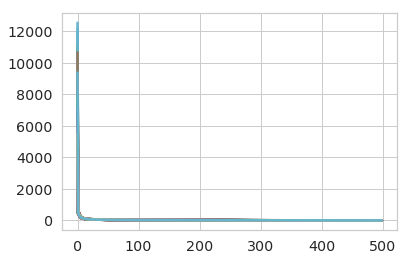

In [37]:
plt.plot(Rs_all[-1].T)

In [42]:
cumvar = np.cumsum(Rs_all[-1]**2,-1) / np.sum(Rs_all[-1]**2,-1,keepdims=True)

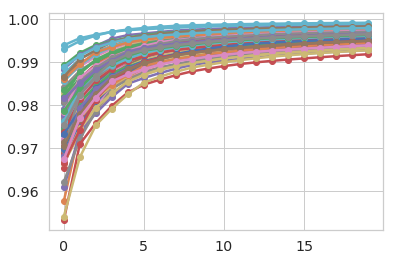

In [53]:
plt.plot(cumvar[:,:20].T, 'o-');
# plt.ylim([0,1.1])